In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    print("using cuda:", torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
# h5py를 임포트 하여 데이터 엑세스
import h5py

import numpy
import matplotlib.pyplot as plt
#(218, 178, 3)

In [ ]:
import pandas as pd

from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np

def crop_centre(img_array):# (218,178,3) -> (3,128,128) 축소? 자르기?
    h,w,_ = img_array.shape
    center_h = h//2
    center_w = w//2

    cropped_array =img_array[center_h-64:center_h+64,center_w-64:center_w+64,:]
    return cropped_array

class CelebaDataset(Dataset):
    
    file_object=h5py.File('mount/My Drive/Colab Notebooks/firstGAN/celeba_dataset/celeba_aligned_small.h5py', 'r')
    dataset = file_object['img_align_celeba']
    # read csv
    def __init__(self):
        super().__init__()
        
    def __len__(self):
        return len(CelebaDataset.dataset)
    def __getitem__(self, index): #(1,3,128,128)로 자르기
        array = np.array(CelebaDataset.dataset[f'{index}.jpg'])/255.0
        cropped_array = crop_centre(array).transpose(2,0,1)
        return torch.cuda.FloatTensor(cropped_array)
        #return torch.cuda.FloatTensor(array)
        
    def plot_image(self,index):
        image = numpy.array(CelebaDataset.dataset[f'{index}.jpg'])
        cropped_array = crop_centre(image)
        #array = np.array(CelebaDataset.dataset[f'{index}.jpg'])/255.0
        plt.figure(figsize=(3,3))
        plt.imshow(cropped_array)

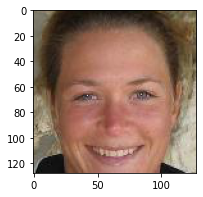

In [ ]:
celeba_dataset=CelebaDataset()
celeba_dataset.plot_image(30)

In [ ]:
class myView(torch.nn.Module):
    def __init__(self,shape):
        super().__init__()
        self.shape = shape,
    def forward(self,x):
        return x.view(*self.shape)

In [ ]:
from torch.optim import SGD,Adam
from torch.nn import MSELoss,BCELoss

class D(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential( #(1,3,128,128)
            torch.nn.Conv2d(3,256,8,2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2),
            #(15616x61) <- (256,61,61)

            torch.nn.Conv2d(256,256,8,2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2),
            #(6912,27) <- (256,27,27)

            torch.nn.Conv2d(256, 3, kernel_size=8, stride=2),
            torch.nn.LeakyReLU(0.2),
            #(3,10,10)

            myView(3*10*10),
            torch.nn.Linear(3*10*10,1),            
            torch.nn.Sigmoid()
        )
        self.optimizer = Adam(self.parameters(),lr=0.0001)
        self.loss_fn = BCELoss()
        self.loss_hist = []
        self.counter=0
        
    def forward(self,x):
        return self.model(x)

    def train(self,x,label):
        self.optimizer.zero_grad()
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()

        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(12,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.2)
        plt.title('discriminator loss')
        plt.show()    
        

In [ ]:
def gen_random(size):
    return torch.randn(size)

In [ ]:
class G(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(100,3*11*11),
            torch.nn.LeakyReLU(0.2),

            myView((1,3,11,11)),

            torch.nn.ConvTranspose2d(3,256,8,2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2),
            #7168x28 <-(256,28,28)
            torch.nn.ConvTranspose2d(256,256,8,2),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2),
            #15872x62 <-(256,62,62)

            torch.nn.ConvTranspose2d(256,3,8,2,padding=1),
            torch.nn.BatchNorm2d(3),
            #384x128 <-(3,128,128)

            torch.nn.Sigmoid(),
        )

        self.optimizer = Adam(self.parameters(),lr=0.0001)
        
        self.loss_hist = []

    def forward(self,x):
        return self.model(x)
    
    def train(self,D,x,label):
        self.optimizer.zero_grad()
        fake_pred = self.forward(x)
        y_pred = D(fake_pred)
        loss = D.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()
        
        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(12,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('generator loss')
        plt.show()
    
    def visualize_8img(self,x):
        fake_pred = self.forward(x).detach().cpu().numpy() # size(16,28*28)
        fake_pred = fake_pred.reshape((-1,28,28)).transpose((1,0,2)).reshape((28,-1))

        plt.figure(figsize=(16,2))
        plt.title('generator prediction')
        plt.imshow(fake_pred, cmap='Blues')

In [ ]:
%%time

dataloader = DataLoader(celeba_dataset,1)
d = D()
d.to(device)
g= G()
g.to(device)



for i,data in enumerate(dataloader): #enumerate 가능한가? 몇 epoch인지 출력하고 싶은데

    d.train(data,torch.cuda.FloatTensor([1.0]))
    d.train(g(gen_random(100)).detach(),torch.cuda.FloatTensor([0.0]))
    g.train(d,gen_random(100),torch.cuda.FloatTensor([1.0]))

    # d.train(data,torch.tensor([1.0],dtype=torch.float32))
    # d.train(g(gen_random(100)).detach(),torch.tensor([0.0],dtype=torch.float32))
    # g.train(d,gen_random(100),torch.tensor([1.0],dtype=torch.float32))

    if i%(100)==0:
        print(f"i {i}")   
        if (d.loss_hist):
            print(f'g loss {g.loss_hist[-1]}')
            print(f'd loss {d.loss_hist[-1]}')

i 0
g loss 0.6977177262306213
d loss 0.8580697178840637
i 100
g loss 4.582379341125488
d loss 0.009780154563486576
i 200
g loss 6.348437786102295
d loss 0.0002262252091895789
i 300
g loss 1.5779337882995605
d loss 0.34210148453712463
i 400
g loss 1.2750083208084106
d loss 0.02255868911743164
i 500
g loss 5.853934288024902
d loss 0.004996183328330517
i 600
g loss 8.444855690002441
d loss 0.00023952014453243464
i 700
g loss 5.762911796569824
d loss 0.020134875550866127
i 800
g loss 1.4688560962677002
d loss 0.045053012669086456
i 900
g loss 4.211738109588623
d loss 0.0010127186542376876
i 1000
g loss 1.7345054149627686
d loss 0.01755603775382042
i 1100
g loss 4.1261162757873535
d loss 0.004056983161717653
i 1200
g loss 4.36227560043335
d loss 0.08045230060815811
i 1300
g loss 1.2099058628082275
d loss 0.0006967229419387877
i 1400
g loss 8.375266075134277
d loss 0.10985195636749268
i 1500
g loss 7.996484756469727
d loss 0.02754666656255722
i 1600
g loss 3.4552135467529297
d loss 0.0029216

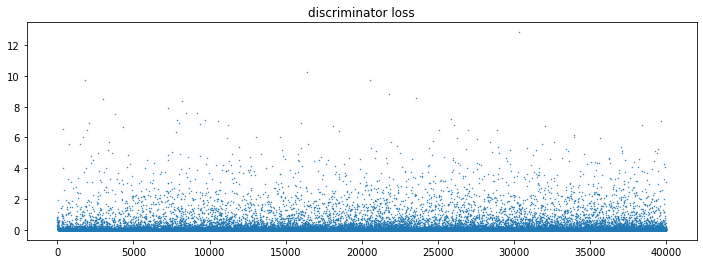

In [ ]:
d.visualize()

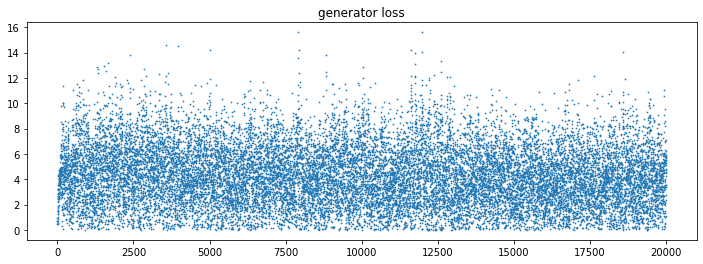

In [ ]:
g.visualize()

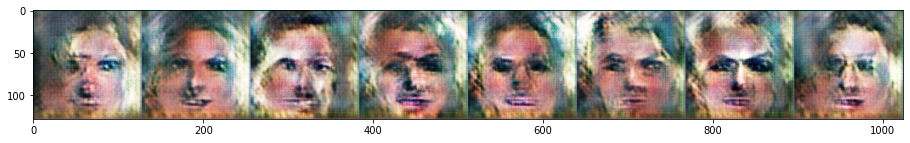

In [ ]:
fake_8img = np.zeros((8,128,128,3))
for i in range(8):
    fake_pred = g.forward(gen_random(100)).detach().cpu().numpy() #(1,3,128,128)
    fake_pred = fake_pred.transpose(0,2,3,1) #(1,128,128,3)
    fake_8img[i] = fake_pred
fake_8img = fake_8img.transpose(1,0,2,3).reshape(128,-1,3)
plt.figure(figsize=(16,2))
plt.imshow(fake_8img)

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.1287698745727539

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.18914079666137695

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  135025 KB |  198328 KB |    9090 GB |    9090 GB |
|---------------------------------------------------------------------------|
| Active memory         |  135025 KB |  198328 KB |    9090 GB |    9090 GB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |  229376 KB |  229376 KB |  229376 KB |       0 B  |
|---------------------------------------------------------------